In [1]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


# Load dataset
uploaded = files.upload()
df = pd.read_csv('final_preprocessed_dataset.csv')

# Drop History of Mental Illness_Yes as it's duplicate of Target
df = df.drop('History of Mental Illness_Yes', axis=1)

# Feature selection: Select features with strongest correlation to Target
corr = df.corr()['Target'].abs().sort_values(ascending=False)
selected_features = corr.index[1:11].tolist()  # Top 10 features excluding Target itself
print("Selected features for CatBoost:", selected_features)

# Update X with selected features
X = df[selected_features]
y = df['Target']

# Display basic dataset info
print("Dataset Shape:", df.shape)
print("Dataset Head:\n", df.head())
print("Dataset Info:")
df.info()

# Target distribution
print("Target Distribution:\n", df['Target'].value_counts(normalize=True))

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Saving final_preprocessed_dataset.csv to final_preprocessed_dataset.csv
Selected features for CatBoost: ['Income', 'Employment Status', 'LFI', 'Education Level', 'Sleep Patterns', 'Age', 'Dietary Habits', 'Smoking Status', 'Alcohol Consumption', 'Physical Activity Level']
Dataset Shape: (249450, 16)
Dataset Head:
         Age  Number of Children  ...  Target       LFI
0  1.596498            1.378132  ...       0  0.382024
1 -1.096950            0.569403  ...       0  0.388857
2 -0.767140           -1.048056  ...       0  0.424602
3 -0.107520           -1.048056  ...       1  0.336091
4 -1.536697           -0.239327  ...       1  0.444943

[5 rows x 16 columns]
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249450 entries, 0 to 249449
Data columns (total 16 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age                               249450 non-null  float64
 1   Number of

Base Model CV Results:
Accuracy: 0.5649 ± 0.0021
Precision: 0.5617 ± 0.0021
Recall: 0.5907 ± 0.0050
F1: 0.5758 ± 0.0027
Roc_auc: 0.5895 ± 0.0034


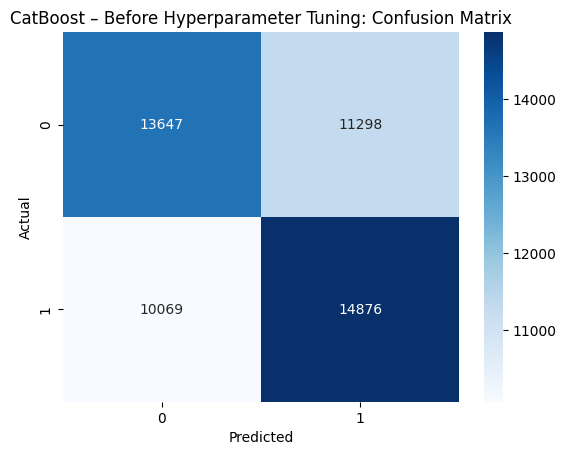

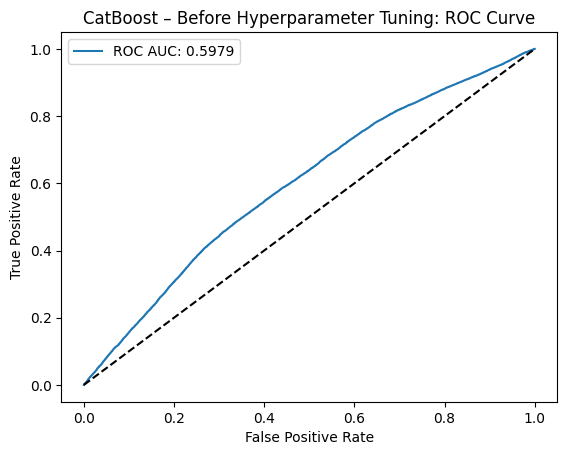

In [5]:
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier

# Initialize the CatBoostClassifier
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(cat_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Display mean ± std of CV metrics
print("Base Model CV Results:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean():.4f} ± {cv_results['test_' + metric].std():.4f}")

# Train on full train set for further evaluation
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
y_prob = cat_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost – Before Hyperparameter Tuning: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('CatBoost – Before Hyperparameter Tuning: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Best Parameters: {'depth': 3, 'iterations': 100, 'learning_rate': 0.01}
Best CV F1 Score: 0.593365862533635
Tuned Model Test Results:
Accuracy: 0.5757265985167368
Precision: 0.5671238717930496
Recall: 0.639807576668671
F1 Score: 0.6012771488311639
ROC AUC: 0.6005392195562247


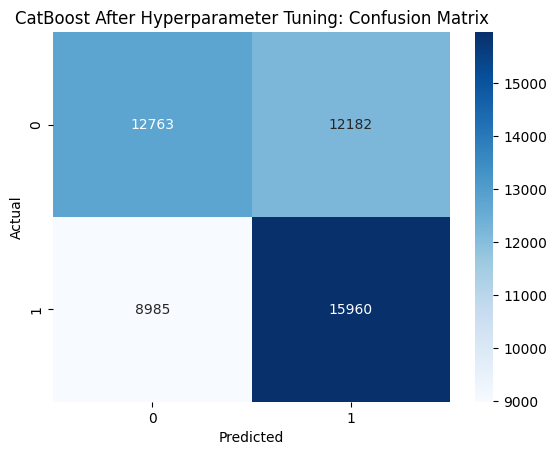

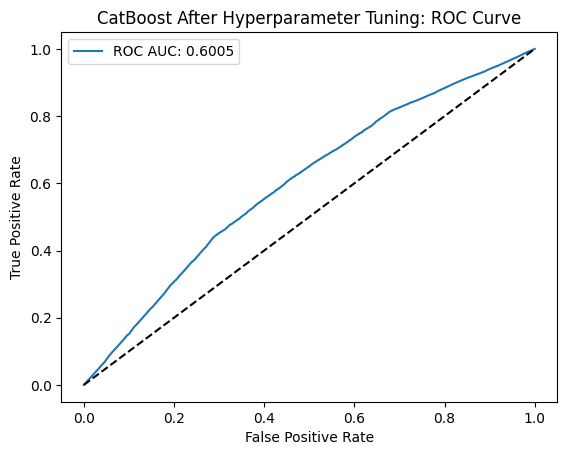

In [6]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and CV results
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

# Retrain with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Improved metrics
print("Tuned Model Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion matrix after tuning
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost After Hyperparameter Tuning: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve after tuning
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('CatBoost After Hyperparameter Tuning: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()